In [1]:
import os
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyOAuth
client_id = SPOTIPY_CLIENT_ID ='bb7c475418484e7784d9cd25b5f9f52c'
client_secret = SPOTIPY_CLIENT_SECRET='b0da0baeeab1499884912aea11f4ca58'
redirect_uri =SPOTIPY_REDIRECT_URI='https://localhost:8080/callback/'


os.environ["SPOTIPY_CLIENT_ID"] = "bb7c475418484e7784d9cd25b5f9f52c"
os.environ["SPOTIPY_CLIENT_SECRET"] = "b0da0baeeab1499884912aea11f4ca58"
os.environ["SPOTIPY_REDIRECT_URI"] = "https://localhost:8080/callback/"

scope = "playlist-modify-public playlist-modify-private user-modify-playback-state user-top-read"
scope +=            " user-modify-playback-state user-read-playback-state user-library-read user-library-modify"
username = 'tonyryanworldwide'

        
token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)        
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope,username=username))


In [2]:
import pandas as pd
from pandas import DataFrame
total = sp.current_user_saved_tracks()['total']
offset = 50
savedtracks = sp.current_user_saved_tracks(limit = 50)['items']
while offset < total:
    
    savedtracks2 =sp.current_user_saved_tracks(limit = 50,offset=offset)['items']
    for track in savedtracks2:
        savedtracks.append(track)
    offset += 50

    
trackinfo ={}   
for trackex in savedtracks:
    id = trackex['track']['id']
    name = trackex['track']['name']
    artistid = trackex['track']['artists'][0]['id']
    seconds = trackex['track']['duration_ms']/1000
    trackinfo[trackex['track']['id']] = {"artist" : artistid,"name":name,"seconds":seconds}
#     trackinfo['loudness'] = sp.audio_features(id)[0]['loudness']
    
trackdf = pd.DataFrame.from_dict(trackinfo,orient = "index").reset_index()
artists = trackdf.artist.unique()
trackdf.columns = ['trackid','artistid','trackname','tracklength_sec']

artistinfo = []
i = 0
while i < len(artists) - 50:
    x=sp.artists(artists[i:i+50])['artists']
    artistinfo.append(x)
    i+=50
artistfinal ={}
for i in artistinfo:
    for j in i:   
        id = j['id']
        name = j['name']
        if len(j['genres']) > 0:
            genre = j['genres']#[0]
        else:
            genre = ''
        artistfinal[id] = {"name":name,"genre": genre}          
artistdf = pd.DataFrame.from_dict(artistfinal,orient = "index").reset_index()
artistdf = artistdf.reset_index()[['index','name','genre']]
artistdf.columns = ['artistid','artistname','genre']
artistdf =artistdf[artistdf['genre']!=''].reset_index()[['artistid','artistname','genre']]




In [3]:
tracks = list(trackinfo.keys())
j = 0
audfeat = []
while j < len(tracks):
    audfeat = audfeat +  sp.audio_features(tracks[j:j+100])
    j += 100



In [4]:
dfAudio = pd.DataFrame(audfeat)
dfAudio.drop(columns=['key','mode','type','uri','track_href','analysis_url'],inplace = True)
audio_features = dfAudio[dfAudio.columns[0:8]]
audio_labels = dfAudio['id'].values



In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA




# Normalize the numeric features so they're on the same scale
audio_features[dfAudio.columns[0:8]] = MinMaxScaler().fit_transform(audio_features[dfAudio.columns[0:8]])



# # Get two principal components
pca = PCA(n_components=2).fit(audio_features.values)
audio_2d = pca.transform(audio_features.values)
audio_2d[0:10]


pca = PCA(n_components=3).fit(audio_features.values)
audio_3d = pca.transform(audio_features.values)
audio_3d[0:10]

<ipython-input-5-bc317cb5150e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  audio_features[dfAudio.columns[0:8]] = MinMaxScaler().fit_transform(audio_features[dfAudio.columns[0:8]])
C:\Users\aryan\Anaconda3\envs\azureml\lib\site-packages\pandas\core\frame.py:3072: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
C:\Users\aryan\Anaconda3\envs\azureml\lib\site-packages\pandas\core\frame.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

array([[-0.06490578,  0.16957569, -0.2588759 ],
       [-0.04372963, -0.20849664,  0.04019093],
       [ 0.40546214,  0.03485949, -0.18532024],
       [ 0.05284688, -0.10454286, -0.05279046],
       [-0.28941508,  0.18049449, -0.16063994],
       [-0.20181871,  0.31053888, -0.36648855],
       [-0.11363362,  0.25338679, -0.27652291],
       [-0.19409697,  0.09236874, -0.12499006],
       [ 0.26619121, -0.43050535,  0.08729486],
       [-0.28925456,  0.12974474, -0.15706756]])

C:\Users\aryan\AppData\Roaming\Python\Python38\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


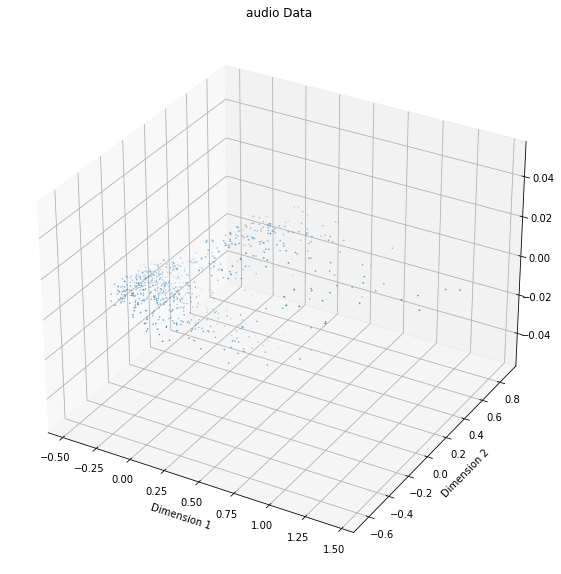

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection='3d')
fig.set_size_inches(10, 10)

plt.scatter(audio_3d[:,0],audio_3d[:,1],audio_3d[:,2])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# plt.zlabel('Dimension 3')
plt.title('audio Data')

plt.show()

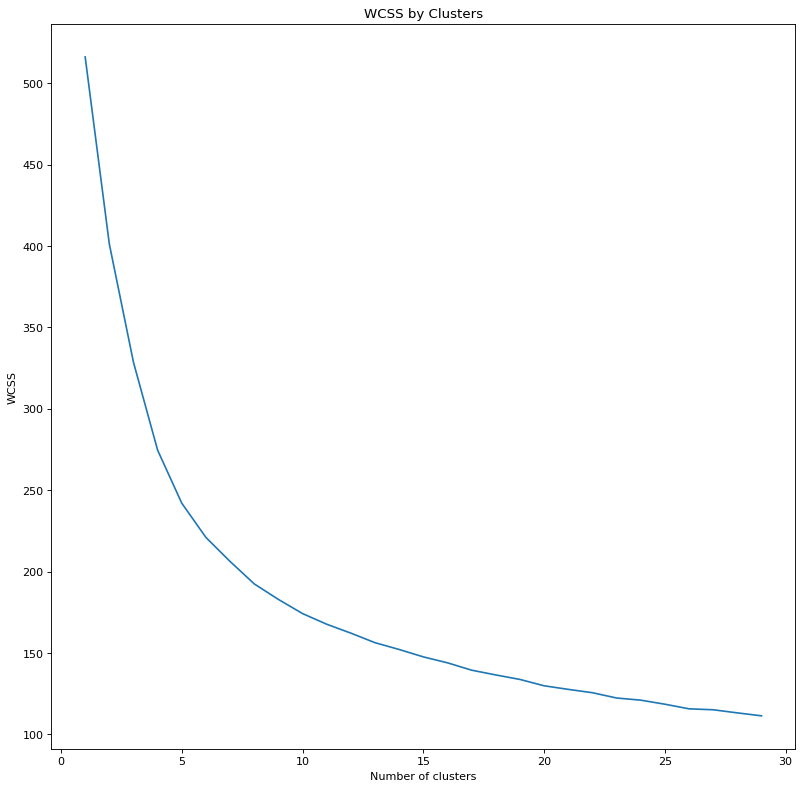

In [7]:
#importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure
%matplotlib inline

# Create 10 models with 1 to x clusters
wcss = []
numclustertest = 30
for i in range(1, numclustertest):
    kmeans = KMeans(n_clusters = i)
    # Fit the Iris data points
    kmeans.fit(audio_features.values)
    # Get the WCSS (inertia) value
    wcss.append(kmeans.inertia_)
figure(figsize=(12, 12), dpi=80)  
#Plot the WCSS values onto a line graph
plt.plot(range(1, 30), wcss)
plt.title('WCSS by Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

In [9]:
def getNumClusters(audio_features):
    numclustertest = 30
    wcss = []
    for i in range(1, numclustertest):
        kmeans = KMeans(n_clusters = i)
        # Fit the Iris data points
        kmeans.fit(audio_features.values)
        # Get the WCSS (inertia) value
        wcss.append(kmeans.inertia_)
    for i in range(2,numclustertest):
        diflast = wcss[i-1] - wcss[i-2]
        dif = wcss[i] - wcss[i-1]
        if dif < diflast:
            n_clusters = i
            break
    return n_clusters


In [10]:
for i in range(2,numclustertest):
    diflast = wcss[i-1] - wcss[i-2]
    dif = wcss[i] - wcss[i-1]
    if dif < diflast:
        n_clusters = i
        break

        
        
n_clusters

12

In [11]:
from sklearn.cluster import KMeans
# Create a model based on n centroids
model = KMeans(n_clusters=n_clusters, init='k-means++', n_init=50, max_iter=300,verbose= True,random_state = 56)

# Fit to the iris data and predict the cluster assignments for each data point
km_clusters = model.fit_predict(audio_features.values)
# View the cluster assignments
km_clusters

Initialization complete
Iteration 0, inertia 231.32207333146144
Iteration 1, inertia 178.3768194896282
Iteration 2, inertia 173.77078913355263
Iteration 3, inertia 172.3000207981988
Iteration 4, inertia 171.59060268233162
Iteration 5, inertia 171.10611052212306
Iteration 6, inertia 170.44681141913688
Iteration 7, inertia 169.93675660026923
Iteration 8, inertia 169.68580266092127
Iteration 9, inertia 169.5025466641969
Iteration 10, inertia 169.39062463357862
Iteration 11, inertia 169.22184583552854
Iteration 12, inertia 169.12846341278367
Iteration 13, inertia 169.08092578860487
Iteration 14, inertia 169.0285314455938
Iteration 15, inertia 169.00140851177534
Iteration 16, inertia 168.9709053404421
Iteration 17, inertia 168.93682925331805
Iteration 18, inertia 168.90605385987394
Iteration 19, inertia 168.88393065556775
Iteration 20, inertia 168.87603361326842
Converged at iteration 20: strict convergence.
Initialization complete
Iteration 0, inertia 222.7653228792018
Iteration 1, inertia

Iteration 23, inertia 165.84872592949884
Iteration 24, inertia 165.8452462937081
Converged at iteration 24: strict convergence.
Initialization complete
Iteration 0, inertia 235.19696101577023
Iteration 1, inertia 185.4612458677056
Iteration 2, inertia 175.85983977039626
Iteration 3, inertia 171.45934216331486
Iteration 4, inertia 169.69456436701262
Iteration 5, inertia 168.75653312040538
Iteration 6, inertia 167.90693320789677
Iteration 7, inertia 167.45718512943964
Iteration 8, inertia 167.1797270552377
Iteration 9, inertia 166.97906095364897
Iteration 10, inertia 166.84427363430382
Iteration 11, inertia 166.74979116471738
Iteration 12, inertia 166.65005687466174
Iteration 13, inertia 166.53400428417515
Iteration 14, inertia 166.45265053806338
Iteration 15, inertia 166.39374040483713
Iteration 16, inertia 166.29538596326032
Iteration 17, inertia 166.20476459406356
Iteration 18, inertia 166.13708520481464
Iteration 19, inertia 166.06662790143585
Iteration 20, inertia 166.01335514266862

Iteration 30, inertia 165.1114967469637
Iteration 31, inertia 165.10684980457359
Iteration 32, inertia 165.0984995525539
Iteration 33, inertia 165.08565229841707
Iteration 34, inertia 165.07275860161724
Iteration 35, inertia 165.04564725901497
Iteration 36, inertia 165.02128974815875
Iteration 37, inertia 165.01019916771799
Iteration 38, inertia 164.98600651314393
Iteration 39, inertia 164.97557087855486
Iteration 40, inertia 164.96402676350047
Iteration 41, inertia 164.95576210258034
Iteration 42, inertia 164.94915724997728
Iteration 43, inertia 164.93759987863967
Iteration 44, inertia 164.9290004328871
Iteration 45, inertia 164.92246995420285
Iteration 46, inertia 164.91169676790523
Iteration 47, inertia 164.89335180110993
Iteration 48, inertia 164.83761191662623
Iteration 49, inertia 164.78271343562906
Iteration 50, inertia 164.70185695778588
Iteration 51, inertia 164.59199474642136
Iteration 52, inertia 164.51772027973678
Iteration 53, inertia 164.4756503437768
Iteration 54, inerti

Iteration 26, inertia 163.90611186428214
Iteration 27, inertia 163.90163779516024
Iteration 28, inertia 163.89954211153045
Converged at iteration 28: center shift 3.5896822657997914e-06 within tolerance 3.6223607365196866e-06.
Initialization complete
Iteration 0, inertia 231.11100421340802
Iteration 1, inertia 175.99109692026053
Iteration 2, inertia 171.13074930165567
Iteration 3, inertia 168.82459106018453
Iteration 4, inertia 167.77870178768424
Iteration 5, inertia 167.1963242011214
Iteration 6, inertia 166.73369918854962
Iteration 7, inertia 166.36616252880228
Iteration 8, inertia 166.12355602385028
Iteration 9, inertia 165.95876843217914
Iteration 10, inertia 165.7762677495468
Iteration 11, inertia 165.63721552717976
Iteration 12, inertia 165.39693595360683
Iteration 13, inertia 165.1416859890409
Iteration 14, inertia 164.92971811572505
Iteration 15, inertia 164.72577891974055
Iteration 16, inertia 164.5312469799405
Iteration 17, inertia 164.38720571079006
Iteration 18, inertia 164

Initialization complete
Iteration 0, inertia 241.64527095017246
Iteration 1, inertia 178.2782742410882
Iteration 2, inertia 170.79688286743476
Iteration 3, inertia 168.25917193436692
Iteration 4, inertia 166.72618977483634
Iteration 5, inertia 165.40853945836943
Iteration 6, inertia 164.56137481414137
Iteration 7, inertia 164.22857043489614
Iteration 8, inertia 164.12833871665202
Iteration 9, inertia 164.063923045091
Iteration 10, inertia 164.03988873974322
Iteration 11, inertia 164.02824344242217
Iteration 12, inertia 163.99886716880297
Iteration 13, inertia 163.96101831283917
Iteration 14, inertia 163.92239450720848
Iteration 15, inertia 163.88653864152008
Iteration 16, inertia 163.8614974495514
Iteration 17, inertia 163.8359990621133
Iteration 18, inertia 163.81696444453019
Iteration 19, inertia 163.80606971131846
Iteration 20, inertia 163.7896760295655
Iteration 21, inertia 163.78142305234215
Iteration 22, inertia 163.77603000477123
Iteration 23, inertia 163.77275064194063
Iteratio

Iteration 0, inertia 218.02040900196917
Iteration 1, inertia 170.7846613483809
Iteration 2, inertia 166.39260520627457
Iteration 3, inertia 165.59891764104492
Iteration 4, inertia 165.04472332350912
Iteration 5, inertia 164.3990392493035
Iteration 6, inertia 163.95999511889082
Iteration 7, inertia 163.64813386662902
Iteration 8, inertia 163.42214463274544
Iteration 9, inertia 163.08784359323568
Iteration 10, inertia 162.848955912573
Iteration 11, inertia 162.69912019002678
Iteration 12, inertia 162.57334247200689
Iteration 13, inertia 162.4370960972025
Iteration 14, inertia 162.32140138303038
Iteration 15, inertia 162.27297322417868
Iteration 16, inertia 162.21424417124817
Iteration 17, inertia 162.17973869578364
Iteration 18, inertia 162.1428846291375
Iteration 19, inertia 162.10675097183113
Iteration 20, inertia 162.08748297282642
Iteration 21, inertia 162.04635214104778
Iteration 22, inertia 162.01353113005712
Iteration 23, inertia 161.97867558026726
Iteration 24, inertia 161.972017

array([ 4,  0, 11, ..., 10, 11,  5])

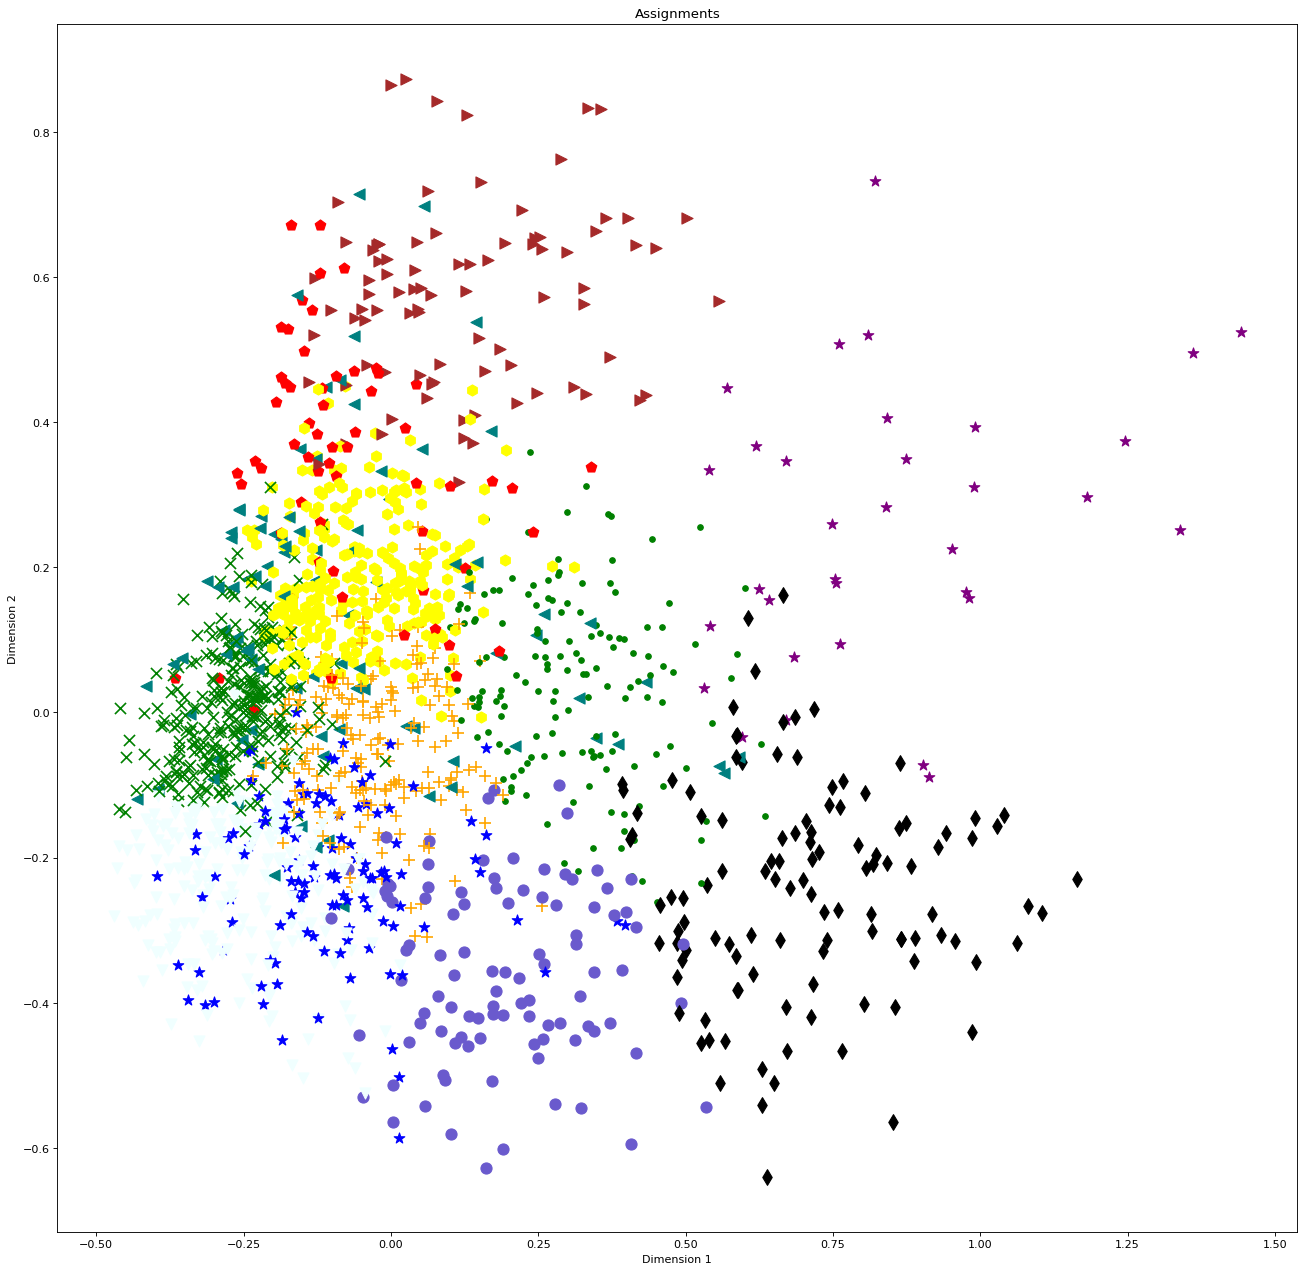

In [22]:
import itertools
from matplotlib.pyplot import figure
col_dic_base = {0:'blue',1:'green',2:'orange',3:'red',4:'yellow',
                5:'black',6:'teal',7: 'brown', 8: 'purple',9: 'azure',
                10:'slateblue',11:'green',12:'indianred',13:'orange',14:'yellow',
                15:'black',16:'teal',17: 'brown', 18: 'purple',19: 'azure',
               20:'thistle',21:'lightcyan'}
mrk_dic_base = {0:'*',1:'x',2:'+',3:'p',4:'h',
                5:'d',6:'<',7:'>',8:'*',9:'v',
                10:'o',11:'.',12:'^',13:'s',14:'$&$',
                15:'$@$',16:'$G$',17:'$4$',18:'$?$',19:'$19$',
               20:'$P$',21:'$H$'}

def plot_clusters(samples, clusters):
    col_dic = dict(itertools.islice(col_dic_base.items(), n_clusters))
    mrk_dic = dict(itertools.islice(mrk_dic_base.items(), n_clusters))
    colors = [col_dic[x] for x in clusters]
    markers = [mrk_dic[x] for x in clusters]
    for sample in range(len(clusters)):
        plt.scatter(samples[sample][0], samples[sample][1], color = colors[sample], marker=markers[sample], s=100)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Assignments')    
    fig = plt.figure(1)
    return fig
    
    
figure(figsize=(20, 20), dpi=80)
figgy = plot_clusters(audio_2d, km_clusters)

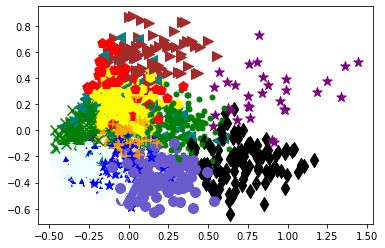

In [31]:
def plot_clusters2(samples, clusters):
    col_dic = dict(itertools.islice(col_dic_base.items(), n_clusters))
    mrk_dic = dict(itertools.islice(mrk_dic_base.items(), n_clusters))
    colors = [col_dic[x] for x in clusters]
    markers = [mrk_dic[x] for x in clusters]
    fig = Figure()
    axis = fig.add_subplot(1, 1, 1)    
    for sample in range(len(clusters)):
        axis.scatter(samples[sample][0], samples[sample][1], color = colors[sample], marker=markers[sample], s=100)

#     plt.xlabel('Dimension 1')
#     plt.ylabel('Dimension 2')
#     plt.title('Assignments')    
#     fig = plt.figure(1)
    return fig
plot_clusters2(audio_2d, km_clusters)

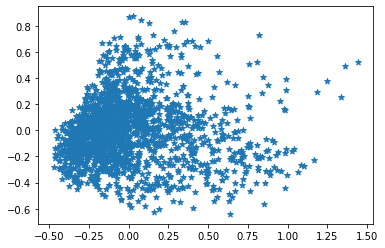

In [28]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
def plot_clusters2(samples, clusters):
    col_dic = dict(itertools.islice(col_dic_base.items(), n_clusters))
    mrk_dic = dict(itertools.islice(mrk_dic_base.items(), n_clusters))
    colors = [col_dic[x] for x in clusters]
    markers = [mrk_dic[x] for x in clusters]    
    xs = []
    ys = []
    c = []
    m = []
    for sample in range(len(clusters)):
        xs.append(samples[sample][0])
        ys.append(samples[sample][1])
        c.append(colors[sample]) 
        m.append(markers[sample])
    fig = Figure()
    axis = fig.add_subplot(1, 1, 1)
    axis.scatter(xs, ys,marker = '*')
    return fig

plot_clusters2(audio_2d, km_clusters)

## Delete Old Clusters

In [ ]:
#Delete
lenplaylists = 1
offset = 0
while lenplaylists > 0:
    playlists = sp.user_playlists(username,offset=offset)['items']
    lenplaylists = len(playlists)
    
    for playlist in playlists:
        name= playlist['name'] 
        id = playlist['uri'][-22:]    
        if name[0:7] =='Cluster':
            print('deleting{0} id {1}'.format(name,id))
            sp.user_playlist_unfollow(user=username, playlist_id = id)
    offset += 20

In [ ]:
classifyer_dict = {}
for x in range(0,len(audio_labels)):
    classifyer_dict[audio_labels[x]] = km_clusters[x]
classifyer_dict

In [ ]:
for cluster in range(0,n_clusters):
    name = 'Cluster Number ' + str(cluster)
    id = sp.user_playlist_create(user=username,name=name)['id']
    globals()[f"cluster_{cluster}"] = []
    for (key, value) in classifyer_dict.items():
#         print(key,value)
        if value == cluster:
#             print('yeah')
            globals()[f"cluster_{cluster}"].append(key)
    tracks = globals()[f"cluster_{cluster}"]
    lengthtracks = len(tracks)
    x= 0
    if lengthtracks <= 100:
        y = lengthtracks
        print("x:{0} y:{1}".format(x,y))
        sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
    else:
        y = 100
        print("1st else: x{} y{}".format(x,y))
        sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
        iteration = 1
        while y >0:
            x = x +100
            print(x,lengthtracks, 'Length of x and tracks')
            if lengthtracks <= x  + 100:
                y = lengthtracks   
                print("inif: x{} y{}".format(x,y))
                sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
                y = 0
            else:
                y = y + 100
                print("else x:{} y:{}".format(x,y))
                sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
            iteration += 1

In [ ]:
column_names = ["artistid", "artistname", "genre"]

finalartist = pd.DataFrame(columns = column_names)

for i in range(0, len(artistdf)):
    df = artistdf[i:i+1][['artistid','artistname']]
#     print(i)
#     print(df)
    genres = artistdf[i:i+1]['genre'][i]
    gf= DataFrame(genres,columns=['genre'])
    product = (
    df.assign(key=1)
    .merge(gf.assign(key=1), on="key")
    .drop("key", axis=1)
    )
    finalartist = finalartist.append(product)
    

In [ ]:
finaltrackinfo = trackdf.merge(finalartist, left_on = 'artistid', right_on = 'artistid', how = 'inner' )
finaltrackinfo['cum_sec'] = finaltrackinfo.groupby('genre')['tracklength_sec'].apply(lambda x: x.cumsum())
finaltrackinfo.to_csv('finaltrackinfo.csv')

In [ ]:
genres = finaltrackinfo.groupby('genre').count().reset_index()[['genre','artistid']]
genres.columns=['genre','count']
genres = genres[(genres['count'] >= 25) & (genres['genre']!= '')].sort_values(by ='count', ascending = False)
genrelist = genres['genre'].tolist()
finaltrackinfo = finaltrackinfo[finaltrackinfo['genre'].isin(genres['genre'])]

In [ ]:
def genrefilter(df,gen,sec_lim = 36000):
    dfin = df['trackid'][(df['genre'] == gen) & (df['cum_sec'] <= sec_lim)]
    return dfin.tolist()#[0:100]



In [ ]:
for gen in genrelist:
    id = sp.user_playlist_create(user=username,name =gen)['id']
    tracks = genrefilter(finaltrackinfo,gen)
#     sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks,position = 0)
    lengthtracks = len(tracks)
    x= 0
    if lengthtracks <= 100:
        y = lengthtracks
        print("x:{0} y:{1}".format(x,y))
        sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
    else:
        y = 100
        print("1st else: x{} y{}".format(x,y))
        sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
        iteration = 1
        while y >0:
            x = x +100
            if lengthtracks < x  + 100:
                y = lengthtracks   
                print("inif: x{} y{}".format(x,y))
                sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
                y = 0
            else:
                y = y + 100
                print("else x:{} y:{}".format(x,y))
                sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
            iteration += 1

In [ ]:
ignorelist = ['Your Top Songs 2018','Best Kings']

def playplaylist():
    currentsong = sp.current_playback()
    if currentsong is None:
        print('Nothing''s playing homie')
        return
    currenturi = currentsong['item']['external_urls']['spotify']
    currentsongid = currentsong['item']['id']
    progress_ms = currentsong['progress_ms']
    playlists = sp.user_playlists(username,offset=0)['items']
    playlistbase = (sp.user_playlists(username,offset=50)['items'])
    for pl in playlistbase:
        playlists.append(pl)
    playlistids =[]
    for playlist in playlists:
        playlistid = playlist['id']
        playlistname = playlist['name']
        context_uri = playlist['external_urls']['spotify']
        playlistids.append(playlistid)
        playlist_tracks = sp.playlist_tracks(playlistid)['items']
        for i in range(0,len(playlist_tracks)):
            trackid = playlist_tracks[i]['track']['id']            
            if (trackid == currentsongid):
                print(trackid)
                if playlistname not in ignorelist:
                    print("trackid: {0} context_uri: {1} playlistname: {2} playlistid: {3}".format(trackid,context_uri,playlistname,playlistid))
                    sp.start_playback(context_uri = context_uri,offset ={'position':i},position_ms=progress_ms)
                    return                
    print('No Playlists')
    
playplaylist()


In [ ]:
currentsong = sp.current_playback()
print(currentsong)

In [ ]:
currentsong = sp.current_playback()
currenturi = currentsong['item']['external_urls']['spotify']
trackid = '3BjNm8Zy8rnCSRquLOXSdu'
playlist_tracks = sp.playlist_tracks('3OQAp1crJ3w7ypjdsvUtFS')['items']
for i in range (0,len(playlist_tracks)):
    track = playlist_tracks[i]['track']['id']
    if track == trackid:
        print(i)
        sp.start_playback(context_uri = contexturi,offset={'position':i})

In [ ]:
currentsong = sp.current_playback()
currentsong['progress_ms']

In [ ]:


if (playlistname not in ignorelist):
    print('hi')

In [ ]:
# sp.start_playback(context_uri = 'https://open.spotify.com/playlist/3BJ5LAJY99NDCFkxqJtnwo')

playlists[0]['external_urls']['spotify']

In [ ]:
currentsongid

# currentsong = sp.current_playback()
# currentson(g['item']['id']

# playlistids[0]

# tracks = sp.playlist_tracks(playlistids[0])['items']
# tracks[0]['track']['id']

## For Debugging Delete CreatedPlaylists

In [ ]:
# playlists =sp.current_user_playlists(offset=100)['items']
playlists = sp.user_playlists(username,offset=50)['items']
for playlist in playlists:
    name= playlist['name']

    
    id = playlist['uri'][-22:]
    
    if name in genrelist:
        print('deleting{0} id {1}'.format(name,id))
        sp.user_playlist_unfollow(user=username, playlist_id = id)

In [ ]:
offset =0
playlistlength =50
while(playlistlength == 50):   
    playlists = sp.user_playlists(username,offset=offset)['items']
    playlistlength = len(playlists)
    print('')
    print("playlistlength {0}".format(playlistlength))
    print('')
    for playlist in playlists:
        name= playlist['name']
#         print(name)
        id = playlist['uri'][-22:]
    
        if name in genrelist:
#             print('')
            print('deleting{0} id {1}'.format(name,id))
            sp.user_playlist_unfollow(user=username, playlist_id = id)
    offset += 50
    

In [ ]:
playlists = sp.user_playlists(username,offset=0)['items']
len(playlists)